In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def detect_corners(image_path, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01, window_size=5):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    cornerness = cv2.cornerHarris(gray_image, block_size, ksize, k)
    threshold = threshold_ratio * cornerness.max()

    h, w_img = cornerness.shape
    suppressed = cornerness.copy()
    for y in range(h):
        for x in range(w_img):
            window = cornerness[max(0, y - window_size):min(h, y + window_size + 1),
                                max(0, x - window_size):min(w_img, x + window_size + 1)]
            if cornerness[y, x] != np.max(window):
                suppressed[y, x] = -np.inf

    final_corners = np.where(suppressed > threshold)
    return final_corners

In [3]:
def pad_patch(patch, target_shape):
    padded_patch = np.zeros(target_shape)
    padded_patch[:patch.shape[0], :patch.shape[1]] = patch
    return padded_patch

def match_corners(img1_corners, img2_corners, img1_gray, img2_gray, patch_size=5):
    matched_pairs = []

    for y1, x1 in zip(*img1_corners):
        min_distance = float('inf')
        matched_corner = None

        for y2, x2 in zip(*img2_corners):
            patch1 = img1_gray[max(0, y1 - patch_size):min(img1_gray.shape[0], y1 + patch_size + 1),
                               max(0, x1 - patch_size):min(img1_gray.shape[1], x1 + patch_size + 1)]

            patch2 = img2_gray[max(0, y2 - patch_size):min(img2_gray.shape[0], y2 + patch_size + 1),
                               max(0, x2 - patch_size):min(img2_gray.shape[1], x2 + patch_size + 1)]

            patch1 = pad_patch(patch1, (2 * patch_size + 1, 2 * patch_size + 1))
            patch2 = pad_patch(patch2, (2 * patch_size + 1, 2 * patch_size + 1))

            distance = np.sum((patch1 - patch2) ** 2)

            if distance < min_distance:
                min_distance = distance
                matched_corner = (y2, x2)

        min_distance_reciprocal = float('inf')
        matched_corner_reciprocal = None
        y2, x2 = matched_corner

        for y1_r, x1_r in zip(*img1_corners):
            patch1_r = img1_gray[max(0, y1_r - patch_size):min(img1_gray.shape[0], y1_r + patch_size + 1),
                                 max(0, x1_r - patch_size):min(img1_gray.shape[1], x1_r + patch_size + 1)]

            patch2_r = img2_gray[max(0, y2 - patch_size):min(img2_gray.shape[0], y2 + patch_size + 1),
                                 max(0, x2 - patch_size):min(img2_gray.shape[1], x2 + patch_size + 1)]

            patch1_r = pad_patch(patch1_r, (2 * patch_size + 1, 2 * patch_size + 1))
            patch2_r = pad_patch(patch2_r, (2 * patch_size + 1, 2 * patch_size + 1))

            distance_r = np.sum((patch1_r - patch2_r) ** 2)

            if distance_r < min_distance_reciprocal:
                min_distance_reciprocal = distance_r
                matched_corner_reciprocal = (y1_r, x1_r)

        if matched_corner_reciprocal == (y1, x1):
            matched_pairs.append(((y1, x1), (y2, x2)))

    return matched_pairs

In [4]:
def draw_matches(img1, img2, matched_pairs):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    h = max(h1, h2)
    w = w1 + w2
    img_matches = np.zeros((h, w, 3), dtype=np.uint8)
    img_matches[:h1, :w1, :] = img1
    img_matches[:h2, w1:w1+w2, :] = img2
    for (y1, x1), (y2, x2) in matched_pairs:
        color = (0, 255, 0)
        cv2.circle(img_matches, (x1, y1), 5, color, 2)
        cv2.circle(img_matches, (x2+w1, y2), 5, color, 2)
        cv2.line(img_matches, (x1, y1), (x2+w1, y2), color, 2)

    return img_matches


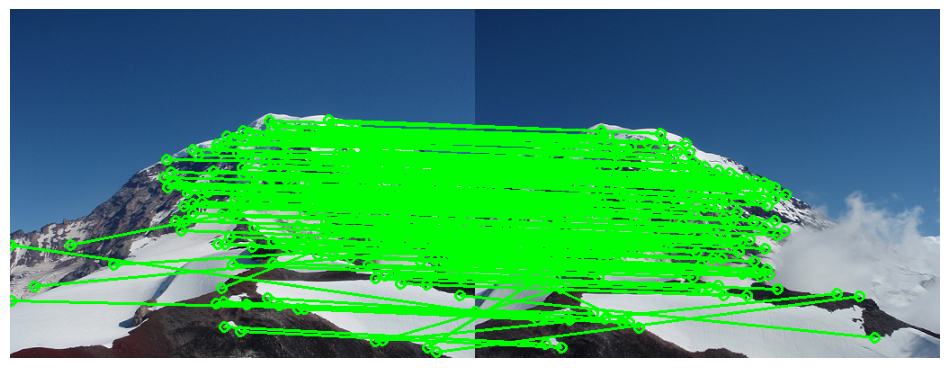

In [5]:
image_path1 = 'Mount1.png'
image_path2 = 'Mount2.png'

img1 = cv2.imread(image_path1)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1_corners = detect_corners(image_path1)

img2 = cv2.imread(image_path2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2_corners = detect_corners(image_path2)

matched_pairs = match_corners(img1_corners, img2_corners, img1_gray, img2_gray)
img_matches = draw_matches(img1, img2, matched_pairs)
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6)) 
plt.imshow(img_matches_rgb)
plt.axis('off')
plt.show()